### 序列数据
> * 实际中很多数据是有时序结构的
> * 电影的评价随时间变化而变化
>> * 拿奖后评分上升，直到奖项被忘记
>> * 看了很多好电影后，人们的期望变高
>> * 季节性：贺岁片、暑期档
>> * 导演、演员的负面报道导致评分变低
> * 音乐、语言、文本和视频都是连续的
>> * 标题“狗咬人”远没有“人咬狗”那么令人惊讶
> * 大地震发生后， 很可能会有几次较小的余震
> * 人的互动是连续的，从网上吵架可以看出
> * 预测明天的股价要比填补昨天遗失的股价更困难

### 统计工具
> * 在时间$t$观察到$x_t$，那么得到$T$个不独立的随机变量$(x_1,...,x_T)\backsim p(X)$
> * 使用条件概率展开：$p(a,b)=p(a)p(b|a)=p(b)p(a|b)$

### 序列模型
> * $p(X)=p(x_1)\cdot p(x_2|x_1)\cdot p(x_3|x_1,x_2)\cdot ...p(x_T|x_1,...x_{T-1})$
> * 对条件概率建模：$p(x_t|x_1,...x_{t-1}) = p(x_t|f(x_1,...x_{t-1}))$，其中$f(x_1,...x_{t-1})$是对见过的数据建模，也称自回归模型
> * ![](../images/SequenceModel.png)

### 马尔科夫假设
> 假设当前数据只跟$\tau$个过去数据点相关：$p(x_t|x_1,...x_{t-1})=p(x_t|x_{t-\tau},...x_{t-1})=p(x_t|f(x_{t-\tau},...x_{t-1}))$，假定$(x_t|f(x_{t-\tau},...x_{t-1}))$是在过去数据上训练一个MLP模型。
> ![](../images/MarkovHypothesis.png)

### 潜变量模型
> 引入潜变量$h_t$来表示过去信息$h_t=f(x_1,...x_{t-1})$,马尔科夫假设中$f(x_1,...x_{t-1})$是个函数，而这里的$h_t$是个值或者说向量
>> 这样$x_t=p(x_t|h_t)$

> ![](../images/LatentVariableModel.png)

### 总结
> * 时序模型中，当前数据跟之前观察到的数据相关
> * 自回归模型使用自身过去数据类预测未来
> * 马尔科夫模型假设当前只跟最近少数数据相关，从而简化模型
> * 潜变量模型使用潜变量来概述历史信息

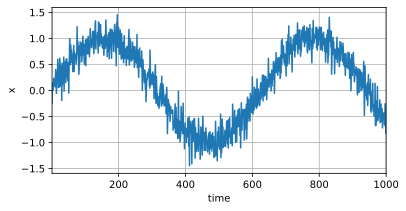

In [1]:
"""使用正弦函数和一些可加性噪声来生成序列数据，时间步长为1,2,...,1000"""
%matplotlib inline
import torch
from torch import nn
from d2l import limutorch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t=x_t$和$x_t=[x_{t-\tau},...,x_{t_1}]$

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    """
        经过下式获取features为：
        [ [x0, x1, x2, x3],
          [x1, x2, x3, x4],
          [.., .., .., ..],
          [x(t-4), x(t-3), x(t-2), x(t-1)]]
    """
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train =16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [4]:
"""使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机"""
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weight)
    return net

loss = nn.MSELoss(reduction='none')

In [12]:
"""训练模型"""
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch{epoch + 1}, loss:{d2l.evaluate_loss(net, train_iter, loss)}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch1, loss:0.06926404232780138
epoch2, loss:0.06023266317943732
epoch3, loss:0.054617992416024205
epoch4, loss:0.05379349042971929
epoch5, loss:0.05149265269438426
epoch6, loss:0.05156399165590604
epoch7, loss:0.05549784431854884
epoch8, loss:0.05042014713088672
epoch9, loss:0.05341810112198194
epoch10, loss:0.05046362966299057


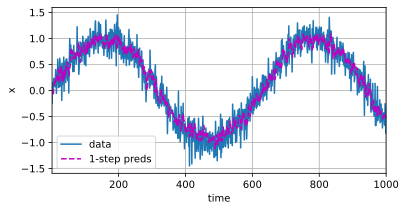

In [14]:
"""预测"""
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
)

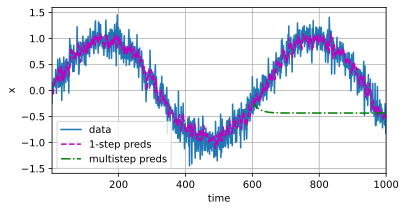

In [17]:
"""进行多步预测"""
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    """使用预测的值进行下一次预测"""
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(),
     multistep_preds[n_train + tau:].detach().numpy()],
    'time', 'x', legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000], figsize=(6, 3)
)

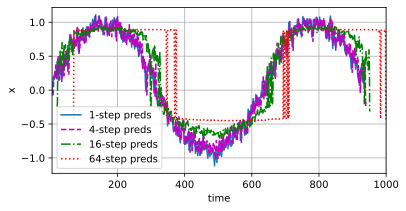

In [19]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot(
    [time[tau + i - 1:T - max_steps + i] for i in steps],
    [features[:, tau + i - 1].detach().numpy() for i in steps],
    'time', 'x', legend=[f'{i}-step preds' for i in steps],
    xlim=[5, 1000], figsize=(6, 3)
)